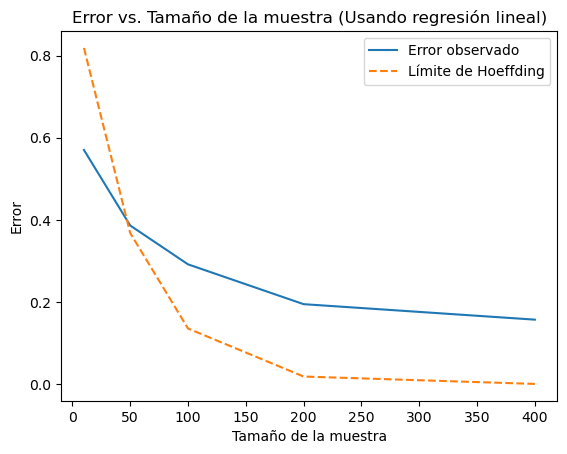

In [1]:
import gzip #Para los dataset que estan en formato gz
import os 
from os.path import isfile, join #Para rutas y archivos
import numpy as np #Para crear arrays
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

dataset = './dataset'

def listFiles(dataset):
    return [join(dataset,file) for file in os.listdir(dataset) if isfile(join(dataset, file))]

# for file in listFiles(dataset):
#     print(file)

#Funcion que obtiene las imagenes
def getImages(dataset):
    for file in listFiles(dataset): #Función usada para extraer los datos que necesitamos
        if "train-images" in file:
            with gzip.open(file, 'rb') as data:
                _= int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype = np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in file:
            with gzip.open(file, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype = np.uint8)

        if "t10k-images" in file:
            with gzip.open(file, 'rb') as data:
                _= int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype = np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in file:
            with gzip.open(file, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype = np.uint8)
    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = getImages(dataset)



# Aplanar las imágenes para poder usarlas en el modelo de regresión logística
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Función para entrenar y evaluar un modelo
def train_and_evaluate(sample_size):
    # Selecciona una muestra aleatoria de imágenes
    indices = random.sample(range(len(x_train_flat)), sample_size)
    x_sample = x_train_flat[indices]
    y_sample = y_train[indices]
    
    # Entrena un modelo simple de regresión logística
    model = LogisticRegression(max_iter=1000)
    model.fit(x_sample, y_sample)
    
    # Evalúa el modelo en el conjunto de prueba
    y_pred = model.predict(x_test_flat)
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    
    return error

# Aplicación de la desigualdad de Hoeffding
def apply_hoeffding(sample_sizes):
    errors = []
    bounds = []
    epsilon = 0.1
    
    for size in sample_sizes:
        error = train_and_evaluate(size)
        errors.append(error)
        
        # Cálculo del límite de Hoeffding
        bound = np.exp(-2 * epsilon ** 2 * size)
        bounds.append(bound)
    
    return errors, bounds

# Prueba con tamaños de muestra crecientes
sample_sizes = [10, 50, 100, 200, 400]
errors, bounds = apply_hoeffding(sample_sizes)

# Grafica los errores y los límites de Hoeffding
plt.plot(sample_sizes, errors, label='Error observado')
plt.plot(sample_sizes, bounds, label='Límite de Hoeffding', linestyle='--')
plt.xlabel('Tamaño de la muestra')
plt.ylabel('Error')
plt.title('Error vs. Tamaño de la muestra (Usando regresión lineal)')
plt.legend()
plt.show()